In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np

df = pd.read_csv("/content/cleaned_train1.csv")


# Features: drop original price and log_price
X = df.drop(columns=['price', 'log_price'])
y = df['log_price']  # use log-transformed price

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")


Train shape: (12966, 20), Test shape: (3242, 20)


In [ ]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

In [ ]:
# --- 2. DEFINE THE CONTENDERS ---
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

models = [
    make_pipeline(StandardScaler(), LinearRegression()),
    make_pipeline(StandardScaler(), Lasso(alpha=0.01, max_iter=10000)),
    make_pipeline(StandardScaler(), Ridge(alpha=1.0)),
    RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=42),
    xgb.XGBRegressor(n_estimators=1000, learning_rate=0.05, n_jobs=-1, random_state=42)
]


model_names = ["Linear Regression", "Lasso", "Ridge", "Random Forest", "XGBoost"]

# --- 3. THE BATTLE LOOP ---
print(f"{'MODEL':<20} | {'R² SCORE':<10} | {'RMSE ($)':<15}")
print("-" * 50)

results = {}

for name, model in zip(model_names, models):
    # Train
    model.fit(X_train, y_train)

    # Predict (Log Scale)
    log_preds = model.predict(X_test)

    # Inverse Transform (Real Dollars)
    actual_preds = np.expm1(log_preds)
    actual_y = np.expm1(y_test)

    # Evaluate
    r2 = r2_score(actual_y, actual_preds)
    mse = mean_squared_error(actual_y, actual_preds)
    rmse = np.sqrt(mse)

    # Save & Print
    results[name] = r2
    print(f"{name:<20} | {r2:.4f}     | ${rmse:,.0f}")

# --- 4. DECLARE WINNER ---
best_model = max(results, key=results.get)
print("-" * 50)
print(f"WINNER: {best_model} with R² = {results[best_model]:.4f}")

MODEL                | R² SCORE   | RMSE ($)       
--------------------------------------------------
Linear Regression    | 0.7345     | $172,645
Lasso                | 0.7246     | $175,837
Ridge                | 0.7345     | $172,645
Random Forest        | 0.8679     | $121,782
XGBoost              | 0.8889     | $111,700
--------------------------------------------------
WINNER: XGBoost with R² = 0.8889


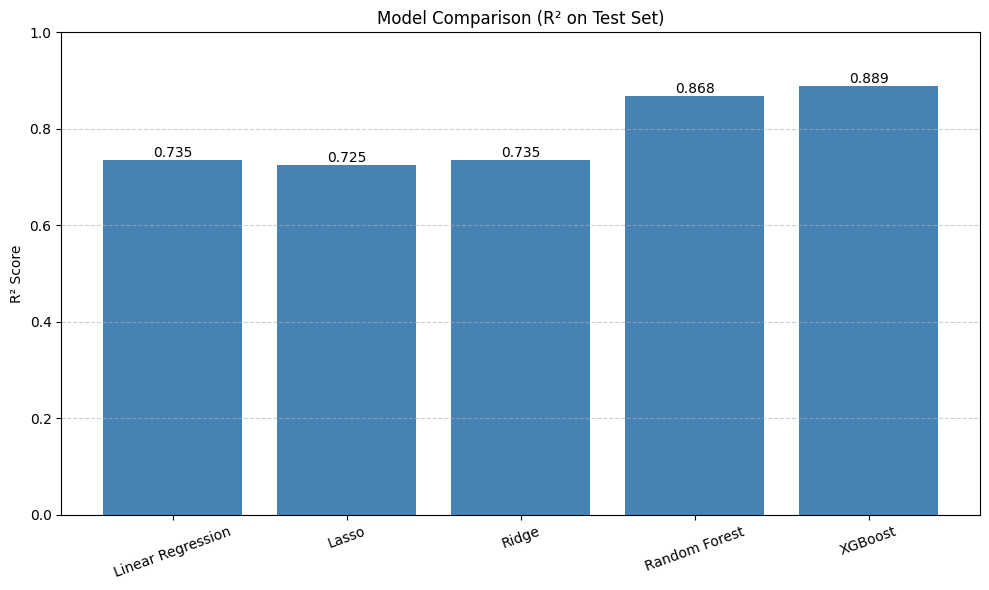

In [ ]:
import matplotlib.pyplot as plt

# Extract data
model_names = list(results.keys())
r2_scores = list(results.values())

# Create bar plot
plt.figure(figsize=(10, 6))
bars = plt.bar(model_names, r2_scores, color="steelblue")

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height,
        f"{height:.3f}",
        ha="center",
        va="bottom",
        fontsize=10
    )

# Formatting
plt.ylabel("R² Score")
plt.title("Model Comparison (R² on Test Set)")
plt.ylim(0, 1)  # R² usually in this range
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.xticks(rotation=20)

plt.tight_layout()
plt.show()


best model is XGBoost regressor. so we will use this model

In [ ]:
# Initialize XGBoost
xgb = XGBRegressor(
    n_estimators=500,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

# Train the model
xgb.fit(X_train, y_train)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.05, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=500,
             n_jobs=None, num_parallel_tree=None, ...)

In [ ]:
# Predict on train and test sets
y_train_pred_log = xgb.predict(X_train)
y_test_pred_log = xgb.predict(X_test)

# Convert back to original price scale
y_train_pred = np.expm1(y_train_pred_log)
y_test_pred = np.expm1(y_test_pred_log)
y_train_original = np.expm1(y_train)
y_test_original = np.expm1(y_test)


Metrics

In [ ]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np

# R²
train_r2 = r2_score(y_train_original, y_train_pred)
test_r2 = r2_score(y_test_original, y_test_pred)

# MAE
test_mae = mean_absolute_error(y_test_original, y_test_pred)

# RMSE
test_rmse = np.sqrt(mean_squared_error(y_test_original, y_test_pred))

print(f"Train R²: {train_r2:.4f}")
print(f"Test R²: {test_r2:.4f}")
print(f"Test MAE: ${test_mae:,.2f}")
print(f"Test RMSE: ${test_rmse:,.2f}")


Train R²: 0.9755
Test R²: 0.8938
Test MAE: $62,306.43
Test RMSE: $109,205.25


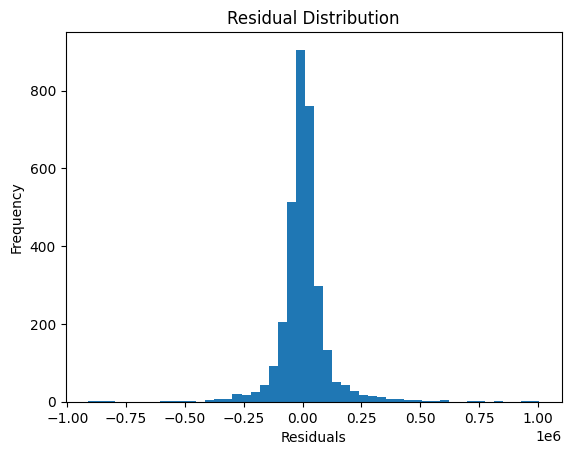

In [ ]:
import matplotlib.pyplot as plt

residuals = y_test_original - y_test_pred
plt.hist(residuals, bins=50)
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.title("Residual Distribution")
plt.show()
